# Test notebook - develop study of the results


In [1]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from earlyrnn import EarlyRNN
import torch
from loss import EarlyRewardLoss
import pandas as pd
import pickle 
import wandb
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_testing import test_dataset, get_test_stats, test_temp_masking
import matplotlib.pyplot as plt
from utils.plots_test import plot_doy_prob, plot_all_doy_probs

In [2]:
import argparse

def parse_args(args=None):
    parser = argparse.ArgumentParser(description='Run ELECTS Early Classification training on the BavarianCrops dataset.')
    parser.add_argument('--backbonemodel', type=str, default="LSTM", choices=["LSTM", "TempCNN"], help="backbone model")
    parser.add_argument('--dataset', type=str, default="bavariancrops", choices=["bavariancrops","breizhcrops", "ghana", "southsudan","unitedstates"], help="dataset")
    parser.add_argument('--alpha', type=float, default=0.5, help="trade-off parameter of earliness and accuracy (eq 6): "
                                                                 "1=full weight on accuracy; 0=full weight on earliness")
    parser.add_argument('--epsilon', type=float, default=10, help="additive smoothing parameter that helps the "
                                                                  "model recover from too early classifications (eq 7)")
    parser.add_argument('--learning-rate', type=float, default=1e-3, help="Optimizer learning rate")
    parser.add_argument('--weight-decay', type=float, default=0, help="weight_decay")
    parser.add_argument('--patience', type=int, default=30, help="Early stopping patience")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu",
                        choices=["cuda", "cpu"], help="'cuda' (GPU) or 'cpu' device to run the code. "
                                                     "defaults to 'cuda' if GPU is available, otherwise 'cpu'")
    parser.add_argument('--epochs', type=int, default=100, help="number of training epochs")
    parser.add_argument('--sequencelength', type=int, default=70, help="sequencelength of the time series. If samples are shorter, "
                                                                "they are zero-padded until this length; "
                                                                "if samples are longer, they will be undersampled")
    parser.add_argument('--hidden-dims', type=int, default=64, help="number of hidden dimensions in the backbone model")
    parser.add_argument('--batchsize', type=int, default=256, help="number of samples per batch")
    parser.add_argument('--dataroot', type=str, default=os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data"), help="directory to download the "
                                                                                 "BavarianCrops dataset (400MB)."
                                                                                 "Defaults to home directory.")
    parser.add_argument('--snapshot', type=str, default="snapshots/model.pth",
                        help="pytorch state dict snapshot file")
    parser.add_argument('--resume', action='store_true')

    if args is not None:
        args = parser.parse_args(args)
    else:
        args = parser.parse_args()

    if args.patience < 0:
        args.patience = None

    return args

custom_args = "--dataset breizhcrops --snapshot ./models/breizhcrops_models/elects_lstm/model.pth --sequencelength 150".split()
args = parse_args(custom_args)
print("cuda is available: ", args.device)
print(args)

cuda is available:  cuda
Namespace(backbonemodel='LSTM', dataset='breizhcrops', alpha=0.5, epsilon=10, learning_rate=0.001, weight_decay=0, patience=30, device='cuda', epochs=100, sequencelength=150, hidden_dims=64, batchsize=256, dataroot='C:\\Users\\anyam\\elects_data', snapshot='./models/breizhcrops_models/elects_lstm/model.pth', resume=False)


## Download the model from wandb 

In [3]:
api = wandb.Api()
entity, project = "aurenore", "MasterThesis"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)
runs_df

,summary,config,name
0,"{'kappa': 0.6793886514194076, '_wandb': {'runt...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",TempCNN-seqlength150
1,"{'elects_earliness': 0.7909663657515034, '_wan...","{'alpha': 0.5, 'device': 'cpu', 'epochs': 100,...",LSTM-seqlength150
2,"{'_step': 87, '_wandb': {'runtime': 28826}, 'a...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",TempCNN-seqlength70
3,"{'harmonic_mean': 0.7233418612452365, 'conf_ma...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",ELECTS-LSTM-hiddendims=32
4,"{'_runtime': 11696.298843383787, 'accuracy': 0...","{'alpha': 0.5, 'device': 'cuda', 'epochs': 100...",ELECTS-LSTM-og


In [6]:
chosen_run_name = "ELECTS-LSTM-og"
# get the corresponding run from runs (not the dataframe, the actual run)
# if list index out of rang error, check if the run name is correct
if chosen_run_name not in runs_df.name.values:
    raise ValueError(f"Run {chosen_run_name} not found in the dataframe")
chosen_run = [run for run in runs if run.name == chosen_run_name][0]
chosen_run_config = chosen_run.config

In [7]:
artifacts = chosen_run.logged_artifacts()
model = [artifact for artifact in artifacts if artifact.type == "model"][-1] # get the latest model artifact
model_path = model.download()
print(model_path)

wandb:   1 of 1 files downloaded.  


c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-z6s1065x-model.pth-v8


## Test.py - Test the model


In [8]:
# ----------------------------- LOAD DATASET -----------------------------
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    nclasses = 9
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    test_ds = BreizhCrops(root=dataroot,partition="eval", sequencelength=args.sequencelength, return_id=True)
    class_names = test_ds.ds.classname
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:46<00:00, 2644.95it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


In [12]:
# ----------------------------- LOAD MODEL -----------------------------
# if no "hidden_dims" in chosen_run_config, use 64
if "hidden_dims" not in chosen_run_config:
    chosen_run_config["hidden_dims"] = 64
if "backbonemodel" not in chosen_run_config:
    chosen_run_config["backbonemodel"] = "LSTM"
if args.hidden_dims != chosen_run_config["hidden_dims"]:
    print(f"Warning: hidden_dims argument {args.hidden_dims} does not match the chosen run's hidden_dims {chosen_run_config['hidden_dims']}. Using the latter.")
    args.hidden_dims = chosen_run_config["hidden_dims"]
if args.sequencelength != chosen_run_config["sequencelength"]:
    print(f"Warning: sequencelength argument {args.sequencelength} does not match the chosen run's sequencelength {chosen_run_config['sequencelength']}. Using the latter.")
    args.sequencelength = chosen_run_config["sequencelength"]
if args.backbonemodel != chosen_run_config["backbonemodel"]:
    print(f"Warning: backbonemodel argument {args.backbonemodel} does not match the chosen run's backbonemodel {chosen_run_config['backbonemodel']}. Using the latter.")
    args.backbonemodel = chosen_run_config["backbonemodel"]

# ----------------------------- LOAD MODEL -----------------------------
model = EarlyRNN(backbone_model=args.backbonemodel, nclasses=nclasses, input_dim=input_dim, hidden_dims=args.hidden_dims, sequencelength=args.sequencelength).to(args.device)
print("model is loading from: ", model_path)
model.load_state_dict(torch.load(os.path.join(model_path, "model.pth")))
criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon)


model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-z6s1065x-model.pth-v8


Extracting labels from dataset Test.


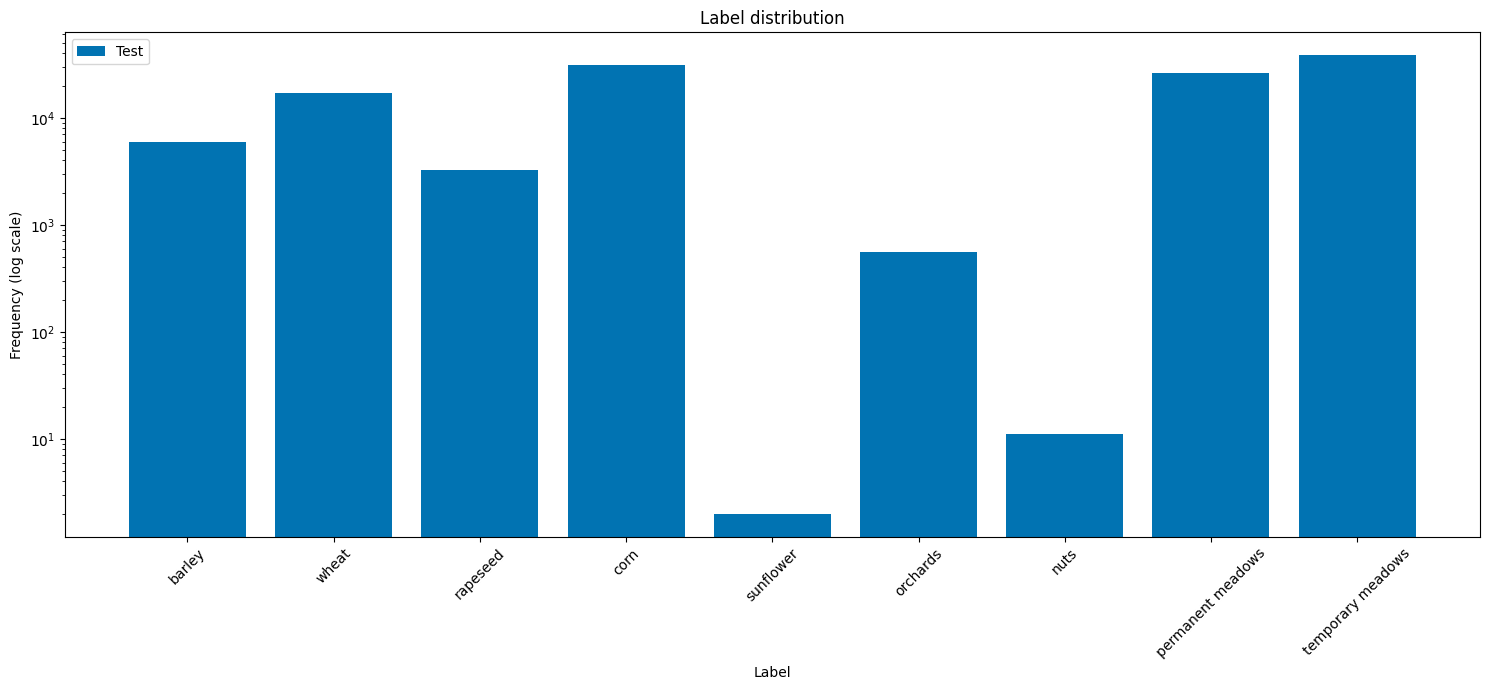

In [4]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

In [55]:
import sys
sys.path.append("..")
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch
import numpy as np
from utils.metrics import harmonic_mean_score
import sklearn.metrics

def test_dataset(model, test_ds, criterion, device, batch_size):
    """
    loads model from snapshot and tests it on the test_ds dataset
    returns a dictionary of variables (probability_stopping, predictions_at_t_stop etc)
    """
    model.eval()

    with torch.no_grad():
        dataloader = DataLoader(test_ds, batch_size=batch_size)
        stats = []
        losses = []
        slengths = []
        max_prob_until_sequence_end_list = []
        t_stop_max_prob_list = []
        for batch in tqdm(dataloader, leave=False):
            X, y_true, ids = batch
            X, y_true = X.to(device), y_true.to(device)

            seqlengths = (X[:,:,0] != 0).sum(1)
            slengths.append(seqlengths.cpu().detach())

            log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
            loss, stat = criterion(log_class_probabilities, probability_stopping, y_true, return_stats=True)
            
            # since data is padded with 0, it is possible that t_stop is after the end of sequence (negative earliness). 
            # we clip the t_stop to the maximum sequencelength here 
            msk = t_stop > seqlengths
            t_stop[msk] = seqlengths[msk]
            # max probabitliy in probability_stopping until the end of sequence (seqlengths)
            max_prob_until_sequence_end = [torch.max(probability_stopping[i, :seqlengths[i]], dim=0) for i in range(len(seqlengths))]
                        
            stat["loss"] = loss.cpu().detach().numpy()
            stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
            stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
            stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["targets"] = y_true.cpu().detach().numpy()
            stat["ids"] = ids.unsqueeze(1)
            
            max_prob_until_sequence_end_list.append(torch.tensor(max_prob_until_sequence_end)[:, 0].cpu().detach().numpy())
            t_stop_max_prob_list.append(torch.tensor(max_prob_until_sequence_end)[:, 1].cpu().detach().numpy())
            stats.append(stat)
            losses.append(loss.cpu().detach().numpy())

        # list of dicts to dict of lists
        stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}
        stats["seqlengths"] = torch.cat(slengths).numpy()
        stats["classification_earliness"] = np.mean(stats["t_stop"].flatten()/stats["seqlengths"])
        stats["max_prob_until_sequence_end"] = np.concatenate(max_prob_until_sequence_end_list)
        stats["t_stop_max_prob"] = np.concatenate(t_stop_max_prob_list).astype(int)

        return np.stack(losses).mean(), stats

In [56]:
# ----------------------------- TEST -----------------------------
# if the files do not exist, they will be created
if os.path.exists(os.path.join(model_path, "testloss.pkl")) and os.path.exists(os.path.join(model_path, "stats.pkl")):
    print("testloss.pkl and stats.pkl exist. Loading them.")
    with open(os.path.join(model_path, "testloss.pkl"), "rb") as f:
        testloss = pickle.load(f)
    with open(os.path.join(model_path, "stats.pkl"), "rb") as f:
        stats = pickle.load(f)
else: 
    print("testloss.pkl or stats.pkl does not exist. Running test.")
    testloss, stats = test_dataset(model, test_ds, criterion, args.device, args.batchsize)

    with open(os.path.join(model_path, "testloss.pkl"), "wb") as f:
        pickle.dump(testloss, f)
    print("test loss saved to", os.path.join(model_path, "testloss.pkl"))

    with open(os.path.join(model_path, "stats.pkl"), "wb") as f:
        pickle.dump(stats, f)
    print("stats saved to", os.path.join(model_path, "stats.pkl"))
    
test_stats = get_test_stats(stats, testloss, args)


testloss.pkl or stats.pkl does not exist. Running test.


  0%|          | 0/479 [00:00<?, ?it/s]

test loss saved to c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-z6s1065x-model.pth-v8\testloss.pkl
stats saved to c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-z6s1065x-model.pth-v8\stats.pkl


In [60]:
print("max_prob_until_sequence_end")
print((stats["max_prob_until_sequence_end"]).shape)
print(stats["max_prob_until_sequence_end"])

print("t_stop_max_prob")
print((stats["t_stop_max_prob"]).shape)
print(stats["t_stop_max_prob"].astype(int))


max_prob_until_sequence_end
(122614,)
[0.9999441  0.67545736 0.9999176  ... 0.0256433  0.9945964  0.14232267]
t_stop_max_prob
(122614,)
[69 32 37 ... 40 38 27]


In [61]:
def get_doy_stop(stats, doys_dict, t_stop_key="t_stop", approximated=True):
    """ returns the day of year at which the model stops for each sample in the stats dictionary
    if approximated is True: 
        - the doys_dict is a dictionary of approximated doys, 
        - the keys are the length of the corresponding doy,
        - the values are the approximated doys (from get_approximated_doy_function)
        - the ids are the lengths of the sequences
    if approximated is False: 
        - the doys_dict is a dictionary of true doys (from the test set)
        - the keys are the ids of the samples
        - the values are the true doys of the samples
        - the ids are the ids of the samples
    """
    doy_stop = []
    if approximated:
        ids_list = stats["seqlengths"]
    else:
        ids_list = stats["ids"][:,0]

    if t_stop_key=="t_stop":
        t_stop_list = stats["t_stop"][:,0]
    elif t_stop_key=="t_stop_max_prob": 
        t_stop_list = stats["t_stop_max_prob"]
    else:
        raise ValueError(f"t_stop_key {t_stop_key} not recognized")
    
    for id, t_stop in zip(ids_list, t_stop_list):
        doys = doys_dict[id]
        if t_stop>=len(doys):
            t_stop = len(doys)-1
        doy_stop.append(doys[t_stop-1])
    doy_stop = np.array(doy_stop)
    return doy_stop

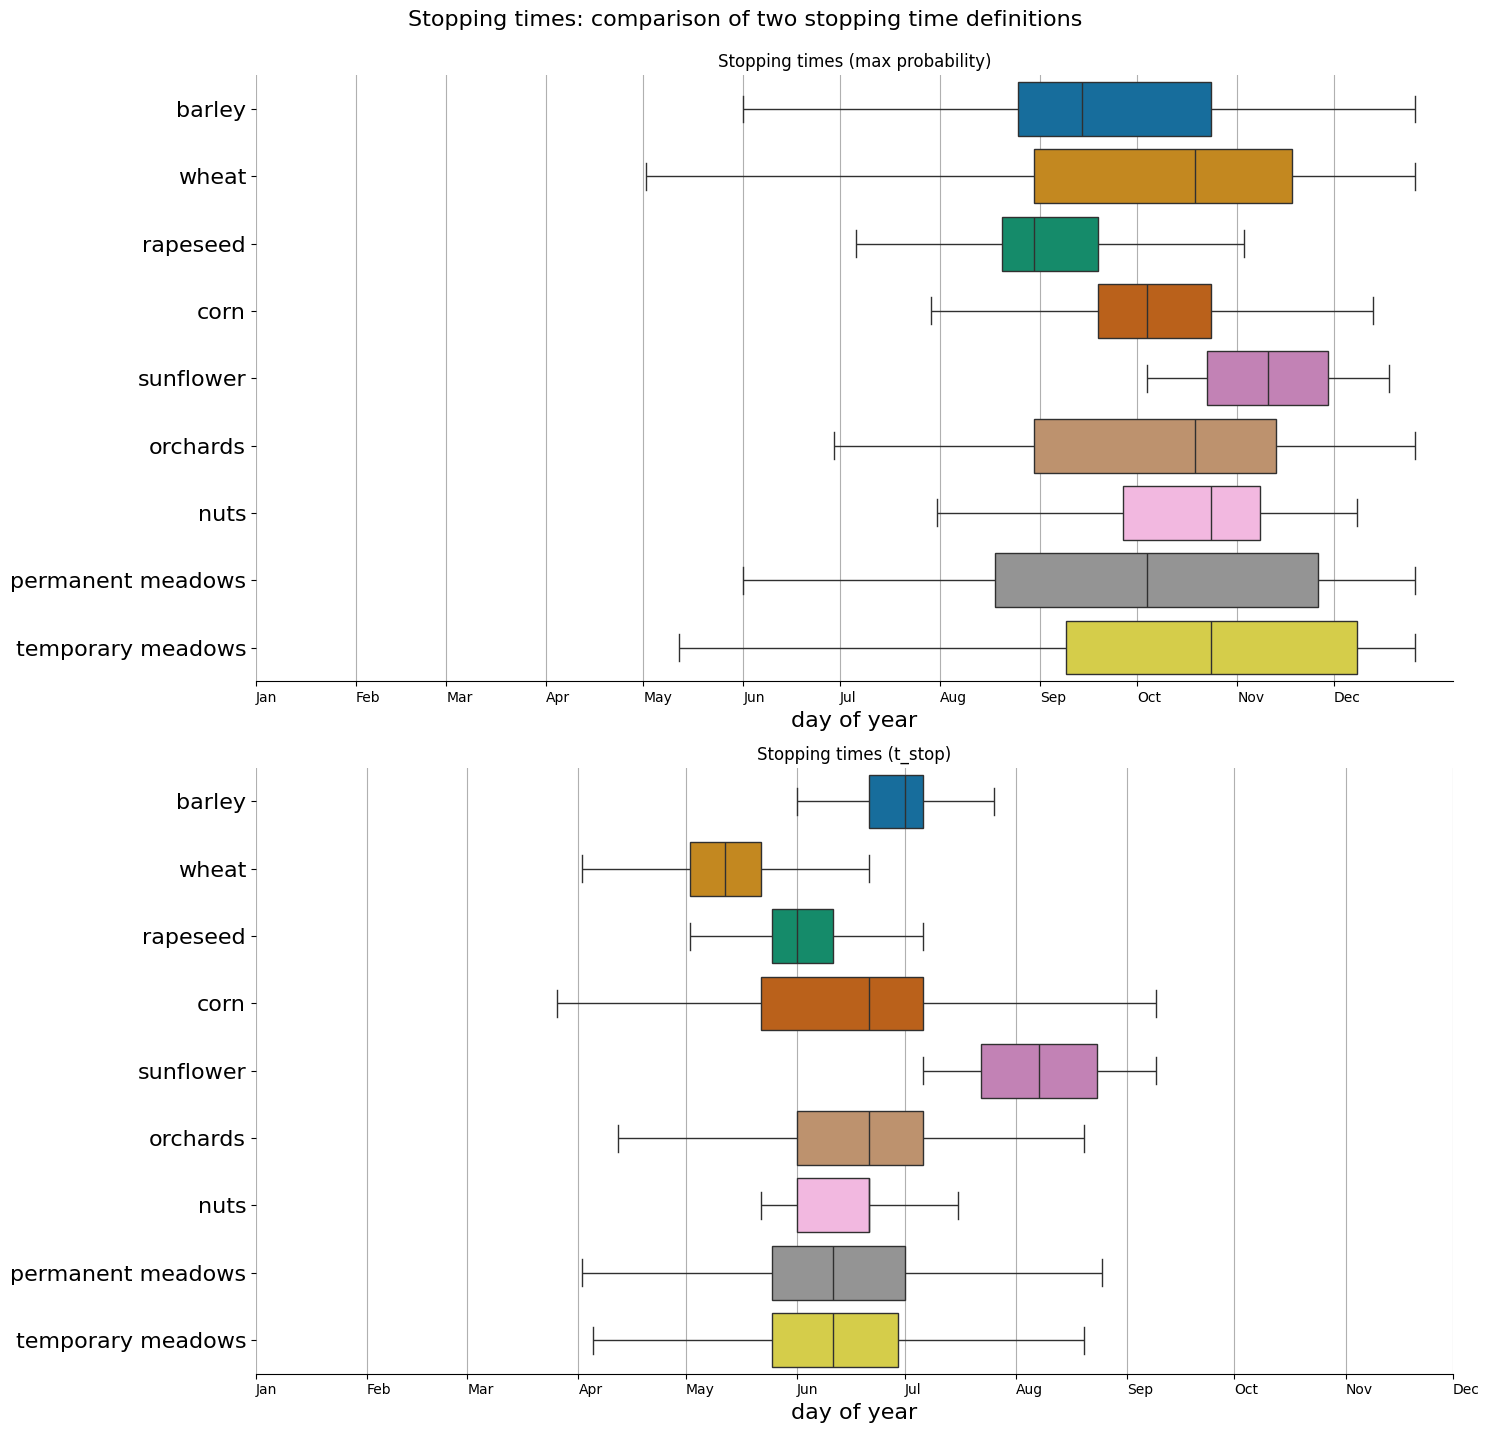

In [70]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(2, figsize=(15, 14))
doys_stop = get_doy_stop(stats, doys_dict_test, t_stop_key="t_stop_max_prob", approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot[0], class_names)

doys_stop = get_doy_stop(stats, doys_dict_test, t_stop_key="t_stop", approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot[1], class_names)

ax_boxplot[0].set_title("Stopping times (max probability)")
ax_boxplot[1].set_title("Stopping times (t_stop)")
fig_boxplot.tight_layout()

fig_boxplot.suptitle("Stopping times: comparison of two stopping time definitions", fontsize=16, y=1.02)
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times_max_prob.png"))

In [95]:
def get_prob_t_stop(prob_stopping):
    # define a function that takes the prob of stopping and returns the output with the same shape, such as 
    # f(d) = [d_1, d_2*(1-d_1), d_3*(1-d_1)*(1-d_2), ...] where d_i is the prob of stopping at i-th timestep
    prob_t_stop = np.zeros_like(prob_stopping)
    for i in range(prob_stopping.shape[1]):
        prob_t_stop[:, i] = np.prod(1-prob_stopping[:, :i], axis=1)*prob_stopping[:, i]
    return prob_t_stop

prob_t_stop = get_prob_t_stop(stats["probability_stopping"])

Text(0.5, 1.0, 'Probability stopping')

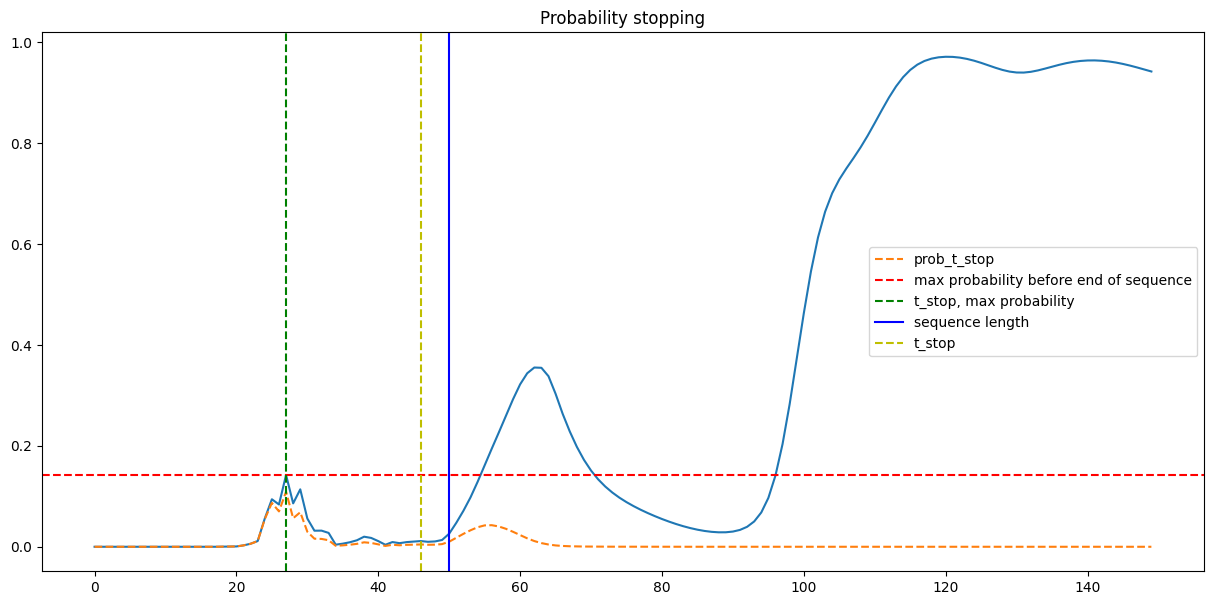

In [102]:
# plot the probability stopping 
fig, ax = plt.subplots(figsize=(15, 7))
index = -1
ax.plot(stats["probability_stopping"][index])
ax.plot(prob_t_stop[index], linestyle='--', label="prob_t_stop")
# horizontal line at max probability
ax.axhline(y=stats["max_prob_until_sequence_end"][index], color='r', linestyle='--', label="max probability before end of sequence")
# vertical line at t_stop
ax.axvline(x=stats["t_stop_max_prob"][index], color='g', linestyle='--', label="t_stop, max probability")
# vertical line at seqlength, with label "sequence length"
ax.axvline(x=stats["seqlengths"][index], color='b',  label="sequence length")
# vertical line at t_stop, with label "t_stop"
ax.axvline(x=stats["t_stop"][index,0], color='y', linestyle='--', label="t_stop")
ax.legend()
ax.set_title("Probability stopping")

Text(0.5, 1.0, 'Probability stopping')

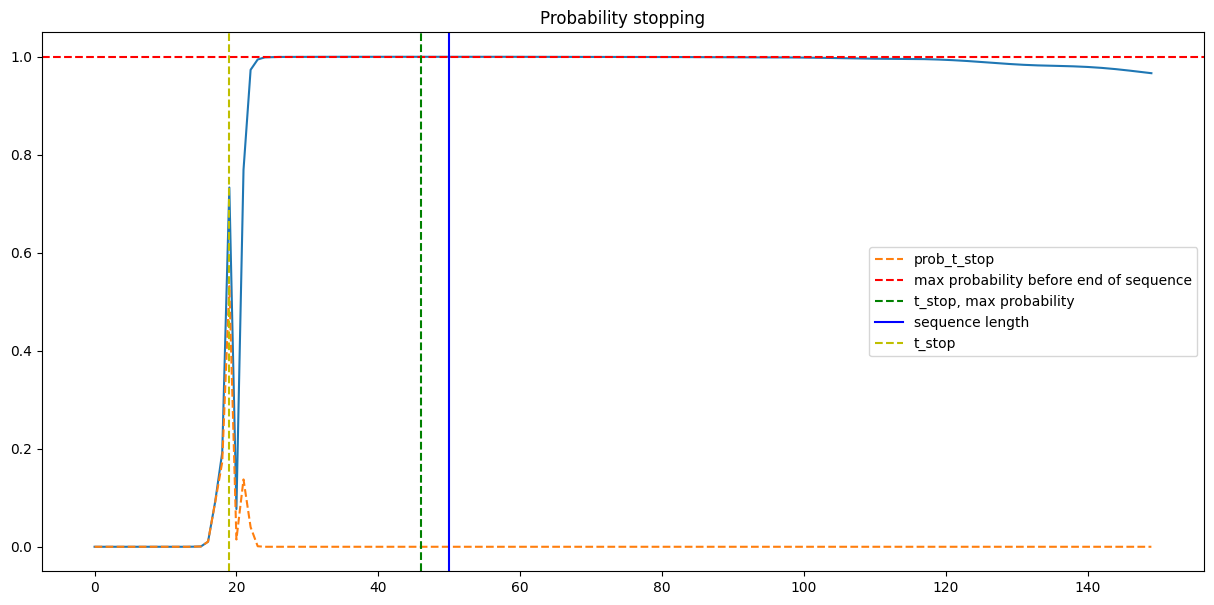

In [103]:
# plot the probability stopping 
fig, ax = plt.subplots(figsize=(15, 7))
index = -5
ax.plot(stats["probability_stopping"][index])
ax.plot(prob_t_stop[index], linestyle='--', label="prob_t_stop")
# horizontal line at max probability
ax.axhline(y=stats["max_prob_until_sequence_end"][index], color='r', linestyle='--', label="max probability before end of sequence")
# vertical line at t_stop
ax.axvline(x=stats["t_stop_max_prob"][index], color='g', linestyle='--', label="t_stop, max probability")
# vertical line at seqlength, with label "sequence length"
ax.axvline(x=stats["seqlengths"][index], color='b', label="sequence length")
# vertical line at t_stop, with label "t_stop"
ax.axvline(x=stats["t_stop"][index,0], color='y', linestyle='--', label="t_stop")
ax.legend()
ax.set_title("Probability stopping")

In [77]:
np.max(stats["probability_stopping"], axis=1)

array([0.9999441 , 0.9402162 , 0.99992573, ..., 0.97634673, 0.9945964 ,
       0.97121406], dtype=float32)

## compute the proability ot t_stop 

In [91]:
prob_stopping = stats["probability_stopping"]
print("shape of prob_stopping", prob_stopping.shape)


def get_prob_t_stop(prob_stopping):
    # define a function that takes the prob of stopping and returns the output with the same shape, such as 
    # f(d) = [d_1, d_2*(1-d_1), d_3*(1-d_1)*(1-d_2), ...] where d_i is the prob of stopping at i-th timestep
    prob_t_stop = np.zeros_like(prob_stopping)
    for i in range(prob_stopping.shape[1]):
        prob_t_stop[:, i] = np.prod(1-prob_stopping[:, :i], axis=1)*prob_stopping[:, i]
    return prob_t_stop

prob_t_stop = get_prob_t_stop(prob_stopping)


shape of prob_stopping (122614, 150)


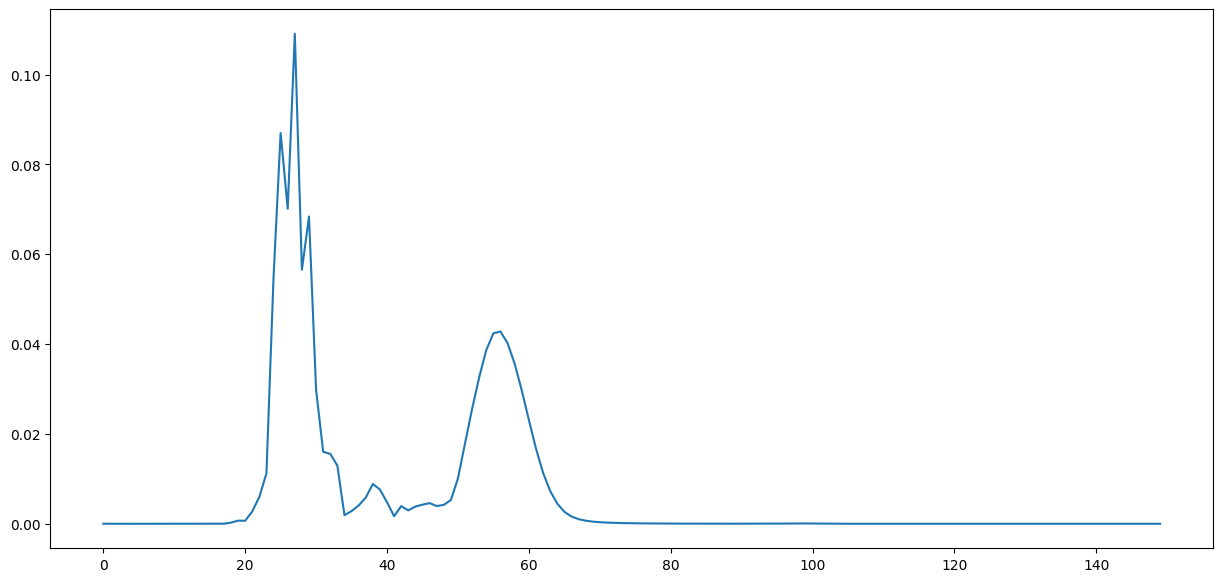

In [92]:
# plot the prob t_stop
fig, ax = plt.subplots(figsize=(15, 7))
index = -1
ax.plot(prob_t_stop[index])


## Graphs

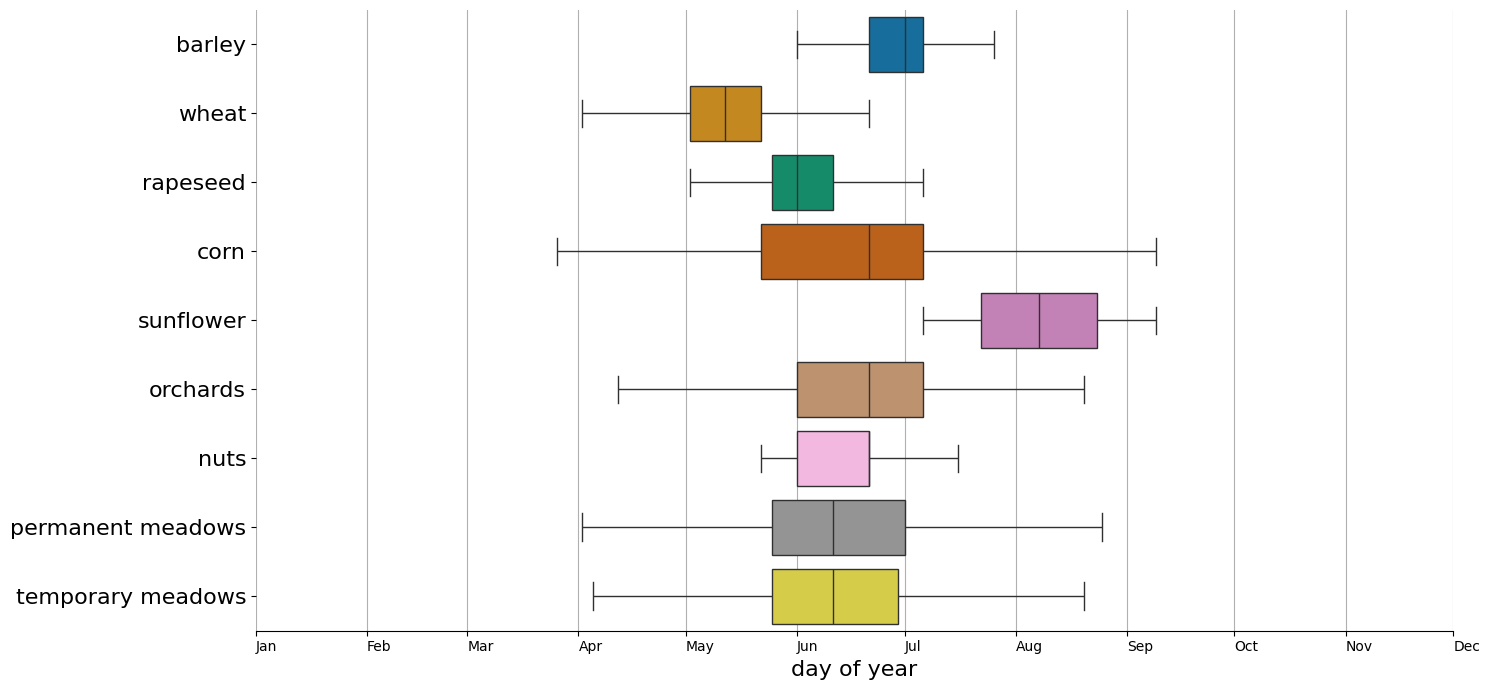

In [63]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times.png"))

(<Figure size 600x400 with 1 Axes>, <Axes: >)

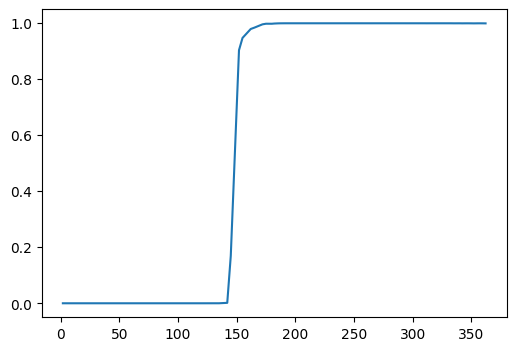

In [15]:
fig, ax = plt.subplots(figsize=(6,4))
plot_doy_prob(6052609, stats, doys_dict_test, model, args.device, test_ds, fig, ax)


for class 0 we have 500 samples
for class 1 we have 500 samples
for class 2 we have 500 samples
for class 3 we have 500 samples
for class 4 we have 2 samples
for class 5 we have 500 samples
for class 6 we have 11 samples
for class 7 we have 500 samples
for class 8 we have 500 samples


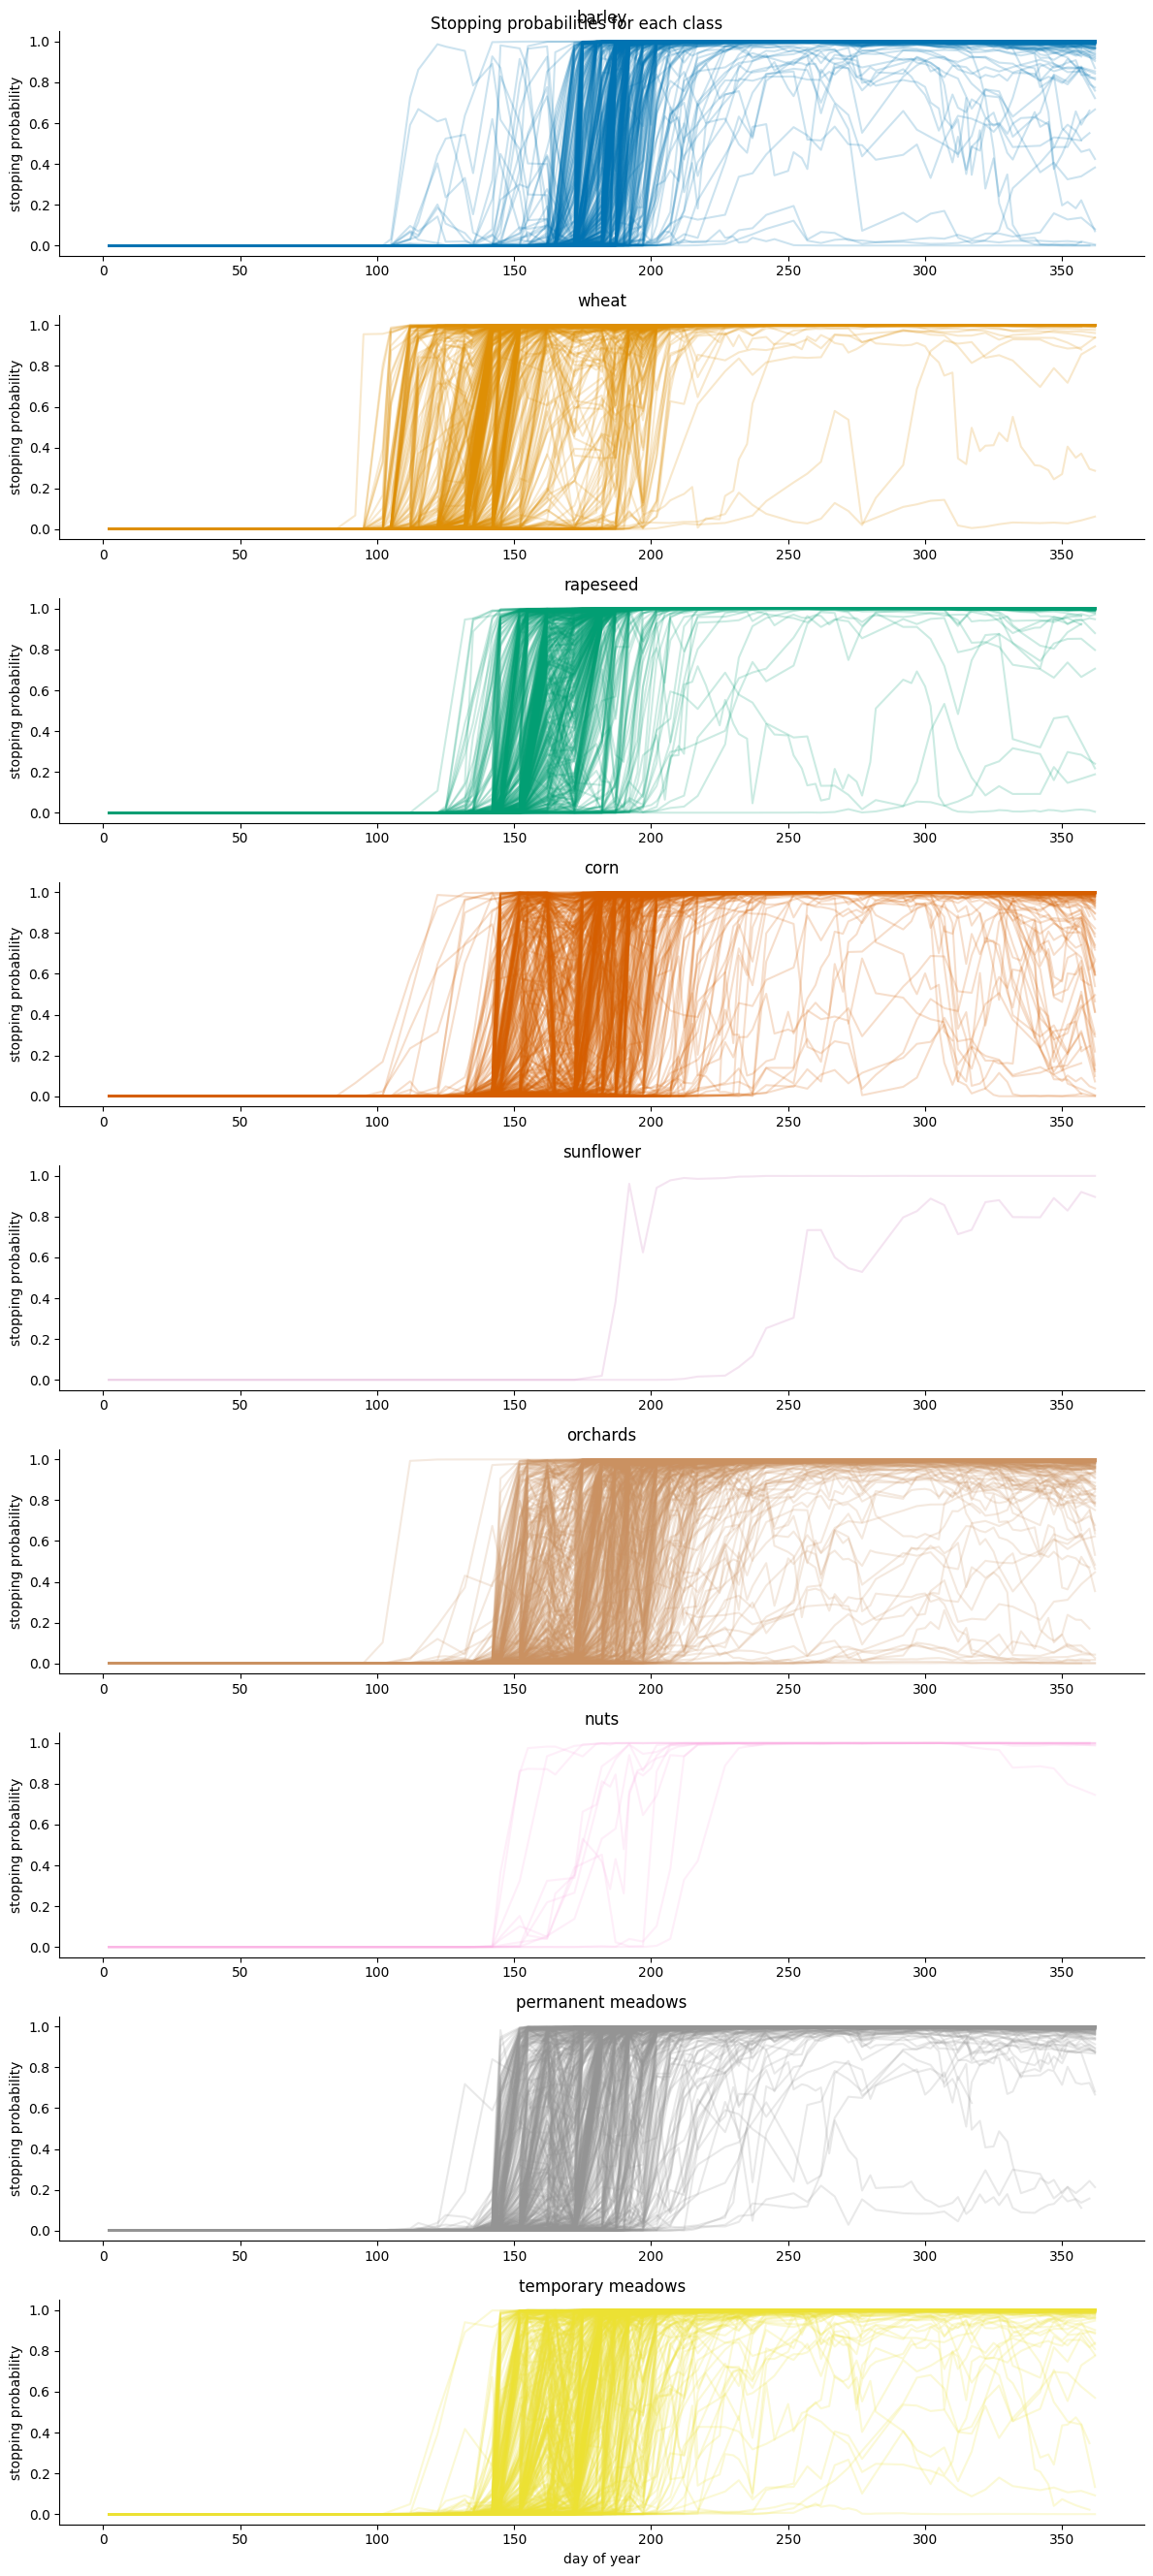

In [16]:
fig, axes = plot_all_doy_probs(stats, doys_dict_test, nclasses=nclasses, class_names=class_names, alpha=0.2, nsamples=500)
fig.savefig(os.path.join(model_path, "doy_probs.png"))

## Temporal masking
For testing as if in realtime, we will use a temporal mask to simulate realtime acquisition of data. When the stopping probability reaches a certain threshold, the decision is made. This is a simple way to simulate the real-time decision-making process.

The threshold is fixed at `thresh_stop = 0.95`.

In [19]:
import sys
sys.path.append("..")
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch
import numpy as np
from utils.metrics import harmonic_mean_score
import sklearn.metrics

def test_temp_masking(model, test_ds, criterion, device, batch_size, sequence_length, thresh_stop:float=0.95, step:int=5):
    """
    loads model from snapshot and tests it on the test_ds dataset, using temporal masking. The model stops predicting when the probability of stopping is above thresh_stop
    returns a dictionary of variables (probability_stopping, predictions_at_t_stop etc)
    """
    model.eval()

    with torch.no_grad():
        dataloader = DataLoader(test_ds, batch_size=batch_size)
        stats = []
        losses = []
        slengths = []
        for batch in tqdm(dataloader, leave=False):
            X, y_true, ids = batch # X.shape : (batchsize, sequence_length, input_dim), y_true.shape : (batchsize, sequence_length)
            X, y_true = X.to(device), y_true.to(device)

            seqlengths = (X[:,:,0] != 0).sum(1)
            slengths.append(seqlengths.cpu().detach())

            # initialize the temporal mask as the same shape as X, with all values set to 0 (no masking)
            temporal_mask = torch.zeros_like(X).to(device)
            unpredicted_seq_mask = torch.ones(X.shape[0], dtype=bool).to(device) # mask for sequences that are not predicted yet
            for i in range(0, sequence_length, step):
                # set the values of the temporal mask to 1, starting from the i-th timestep
                temporal_mask[unpredicted_seq_mask,:i+1,:] = True
                X_masked = X * temporal_mask
                log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X_masked)
                max_prob_until_i = torch.max(probability_stopping[:, :i+1], dim=1)[0]#torch.gather(probability_stopping, 1, t_stop.unsqueeze(1)).squeeze()
                print("for i=", i)
                print("t_stop", t_stop)
                print("max_prob_until_i (which is more like a max of probability until then)", max_prob_until_i)
                unpredicted_seq_mask = unpredicted_seq_mask * (max_prob_until_i < thresh_stop)
                # if i%step==0:
                #     print(f"at i={i}, number of unpredicted sequences", unpredicted_seq_mask.sum())
                # if unpredicted_seq_mask.sum() == 0:
                #     break

            loss, stat = criterion(log_class_probabilities, probability_stopping, y_true, return_stats=True)
            
            # since data is padded with 0, it is possible that t_stop is after the end of sequence (negative earliness). 
            # we clip the t_stop to the maximum sequencelength here 
            msk = t_stop > seqlengths
            t_stop[msk] = seqlengths[msk]
                        
            stat["loss"] = loss.cpu().detach().numpy()
            stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
            stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
            stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["targets"] = y_true.cpu().detach().numpy()
            stat["ids"] = ids.unsqueeze(1)

            stats.append(stat)
            losses.append(loss.cpu().detach().numpy())

        # list of dicts to dict of lists
        stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}
        stats["seqlengths"] = torch.cat(slengths).numpy()
        stats["classification_earliness"] = np.mean(stats["t_stop"].flatten()/stats["seqlengths"])

        return np.stack(losses).mean(), stats

In [20]:
# takes about 30 minutes to compute 
testloss, stats = test_temp_masking(model, test_ds, criterion, args.device, args.batchsize, args.sequencelength, step=5)


  0%|          | 0/479 [00:00<?, ?it/s]

for i= 0
t_stop tensor([ 8,  7,  9, 11, 12, 12,  9, 11,  8, 14, 10, 10,  8,  5,  6,  6,  9, 11,
        12, 12, 13, 10,  7,  7,  9,  7,  6,  8, 11,  8, 10,  7, 11, 10,  7,  9,
         8, 12, 10,  7, 11, 10, 10, 11, 10, 11, 10, 10,  8, 13, 11,  8,  7, 12,
        11, 11, 11,  9,  9,  7,  7, 11,  9,  9, 12,  9, 10, 10, 11,  9, 12, 10,
        11, 11, 10,  8,  5,  8, 12, 11,  6,  6,  8, 10,  5,  9, 11, 10,  6, 13,
         7,  9,  8,  6,  8,  4,  7,  8, 11,  7, 10,  9,  8, 10, 10, 14, 11,  9,
        12, 14, 11, 12, 11, 13,  7, 11,  8, 12, 12, 10, 12, 13, 13, 12, 11, 13,
         8, 11,  8,  9,  8, 10, 10, 14, 13, 12,  7, 12, 10, 11,  7, 13, 12, 11,
         7, 11,  9,  7, 10,  6,  8,  8,  9,  8, 10, 10,  6, 12,  8, 13, 11,  8,
        12, 11, 11, 11, 11, 10,  8, 10, 10,  9, 11, 10,  8, 15, 12,  9, 10, 10,
        11, 11, 12,  7,  8,  9,  9, 10, 11, 12, 10, 11,  8,  8, 11,  9, 11,  7,
         8, 11, 10, 12, 12, 10, 13, 13, 10, 14, 10, 10, 11,  8, 10, 10,  9, 10,
        11,  7, 11,  9, 

KeyboardInterrupt: 

In [128]:
# save the test loss to a csv file
test_stats_df = pd.DataFrame(test_stats, index=[0])
test_stats_df.to_csv(os.path.join(os.path.dirname(args.snapshot), "test_stats.csv"))

# save stats as a dictionary
import pickle
with open(os.path.join(os.path.dirname(args.snapshot), "stats.pkl"), 'wb') as f:
    pickle.dump(stats, f)

#### test if the stats are different from the previous version
the boxplot is the a bit different from the previous version, but the results are similar. We expected this result with LSTM. However the results should be different with TempCNN. 
The only difference here is the approach to get t_stop: in the previous version it was computed as the first time when the cumulative sum of the stopping probabilities achieve 1, and in the current version, it is computed as the first time when the stopping probability is greater than a threshold.

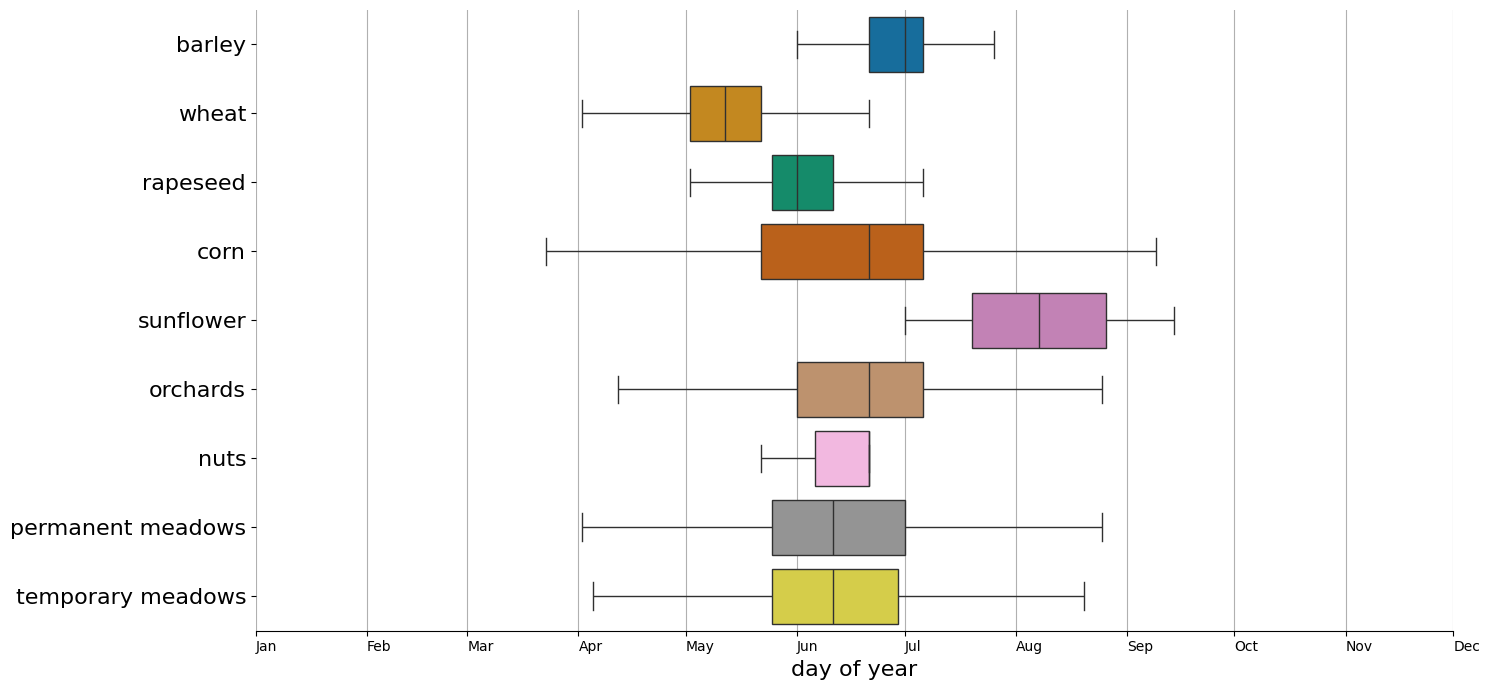

In [133]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)

for class 0 we have 500 samples
for class 1 we have 500 samples
for class 2 we have 500 samples
for class 3 we have 500 samples
for class 4 we have 2 samples
for class 5 we have 500 samples
for class 6 we have 11 samples
for class 7 we have 500 samples
for class 8 we have 500 samples


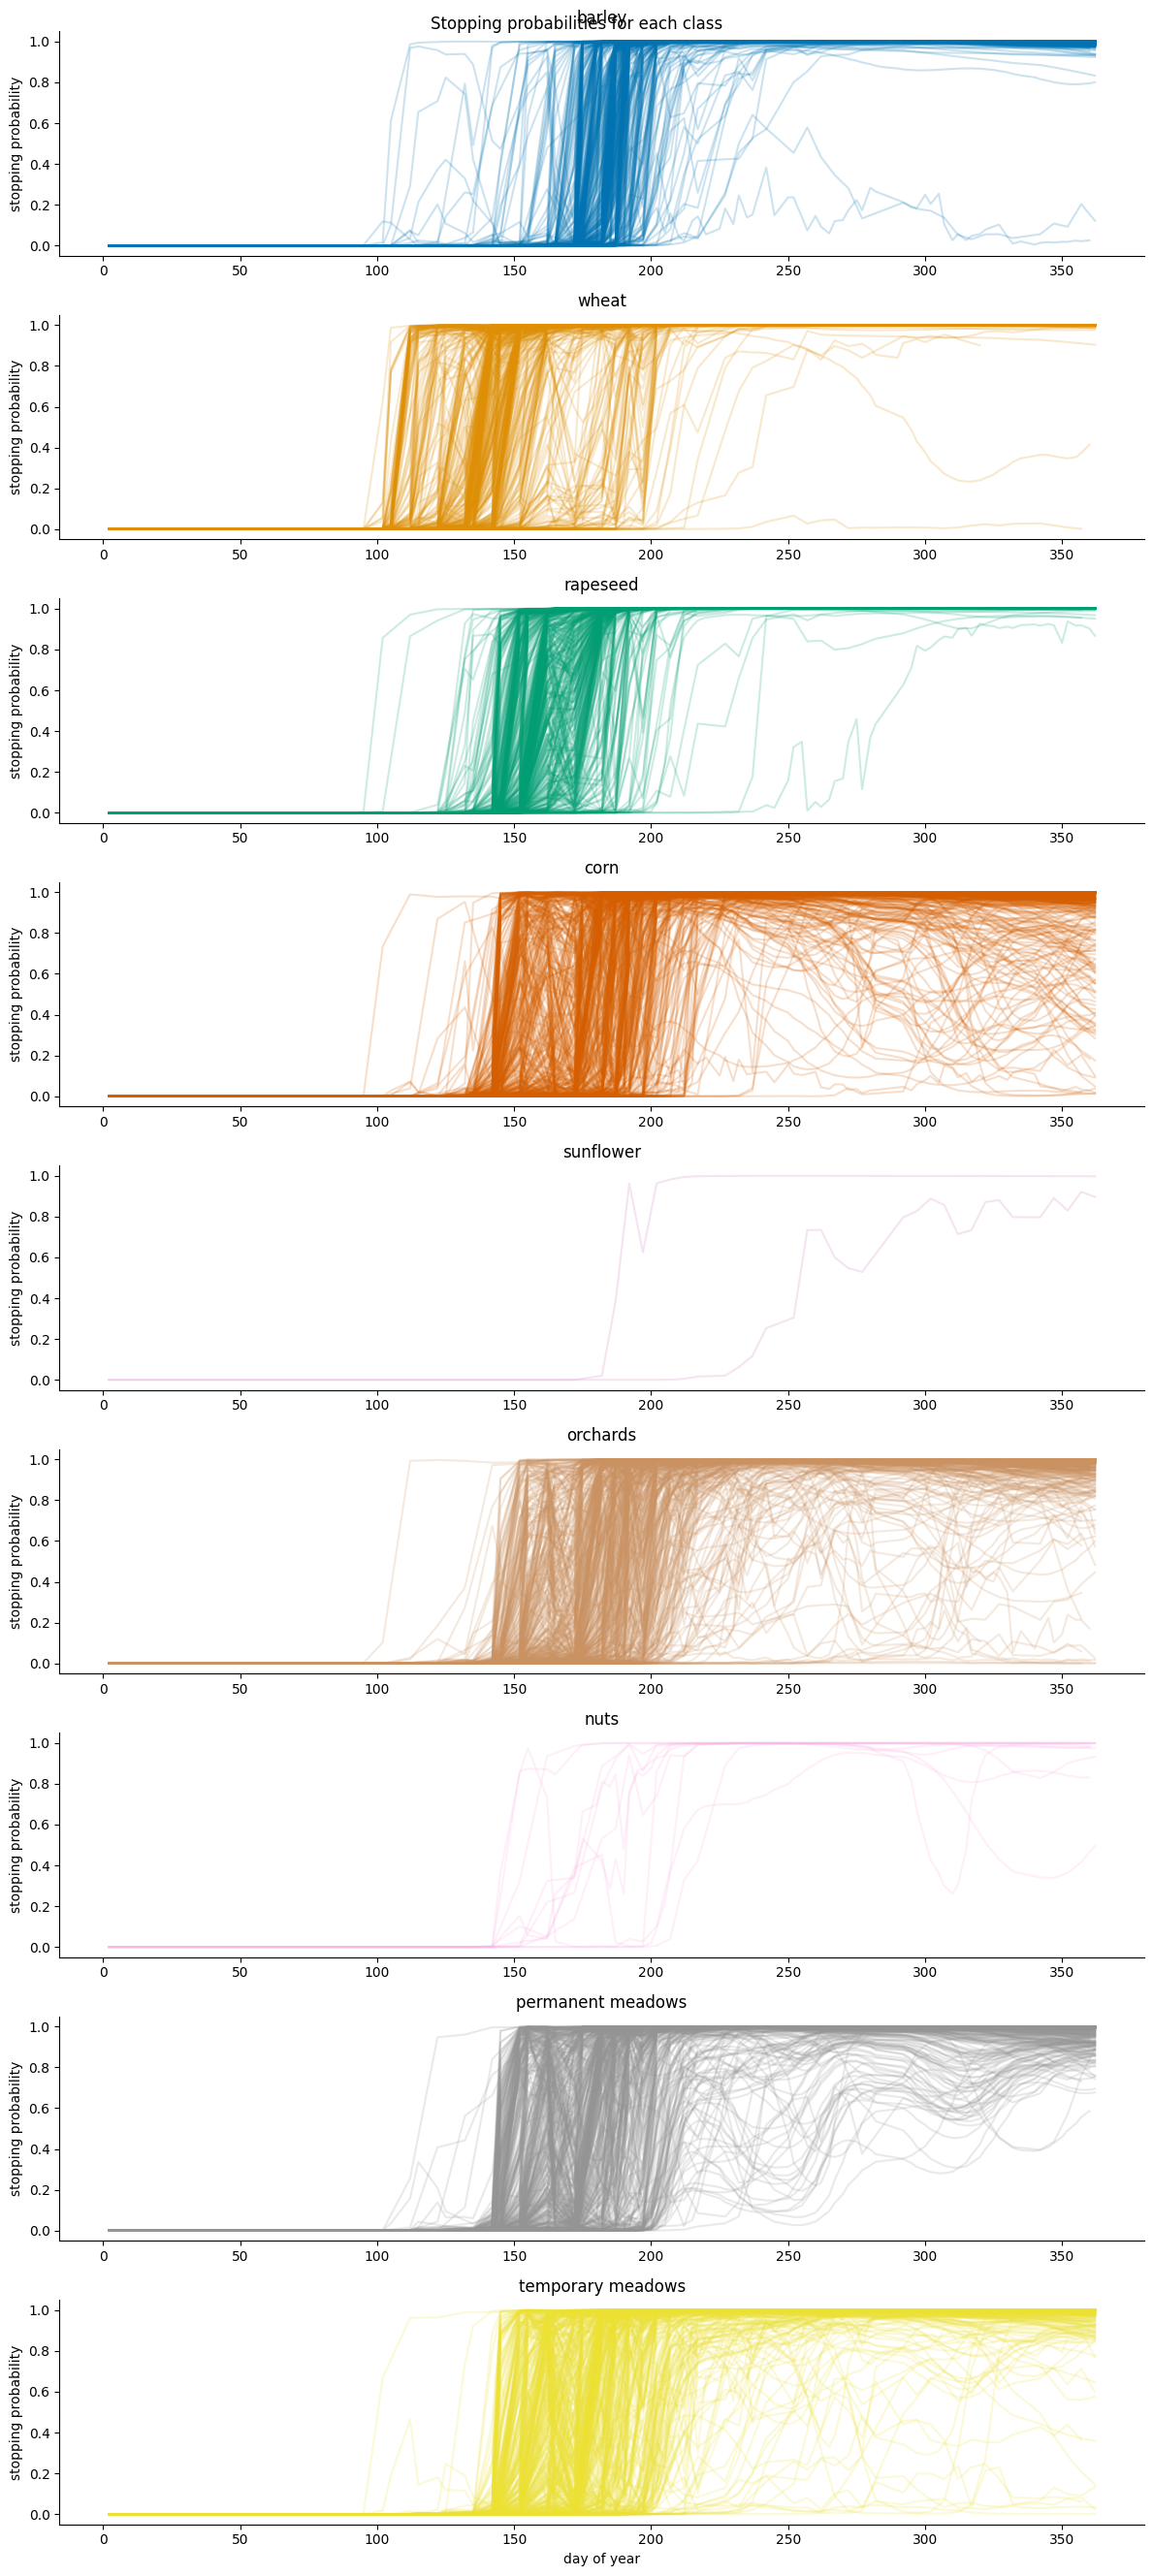

In [134]:
fig, axes = plot_all_doy_probs(stats, doys_dict_test, nclasses=nclasses, class_names=class_names, alpha=0.2, nsamples=500)